In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Datasets/cleansed_listings_hosts_export.csv")

df.describe()

,IS_SUPERHOST,ROOM_TYPE,MINIMUM_NIGHTS,PRICE
count,17499.000000,17499.000000,17499.000000,17499.000000
mean,0.156466,1.571976,10.040117,74.908623
std,0.363307,0.536479,35.057139,114.237300
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,35.000000
50%,0.000000,2.000000,3.000000,55.000000
75%,0.000000,2.000000,5.000000,85.000000
max,1.000000,3.000000,1124.000000,8000.000000


# Market-Safe Preprocessing 

## 1. Price
- Cap prices at 97% to prevent luxury listings affecting the overall performance of the model
- Perform log transformation to stabilize training, prevent price inflation

## 2. Minimum nights
- Convert from numeric to behavior signal to remove noisy extremes
- Using one-hot encode

In [3]:
# Price transformation

price_cap = df.PRICE.quantile(0.97)
df["PRICE_CAPPED"] = df.PRICE.clip(upper=price_cap)

# The formular is log_price = log(price + 1)
# Log transformation allows us to mitigate those extreme values 
df["LOG_PRICE"] = np.log1p(df["PRICE_CAPPED"])

df.describe()

,IS_SUPERHOST,ROOM_TYPE,MINIMUM_NIGHTS,PRICE,PRICE_CAPPED,LOG_PRICE
count,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000
mean,0.156466,1.571976,10.040117,74.908623,69.130065,4.055783
std,0.363307,0.536479,35.057139,114.237300,47.331401,0.620268
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,35.000000,35.000000,3.583519
50%,0.000000,2.000000,3.000000,55.000000,55.000000,4.025352
75%,0.000000,2.000000,5.000000,85.000000,85.000000,4.454347
max,1.000000,3.000000,1124.000000,8000.000000,220.000000,5.398163


In [4]:
# Minimum nights transformation

def min_nights_bin(x):
    if x <= 2: return "short"
    elif x <= 7: return "standard"
    elif x <= 30: return "medium"
    else: return "long"

df["MIN_NIGHTS_BIN"] = df.MINIMUM_NIGHTS.apply(min_nights_bin)

df.head()

,IS_SUPERHOST,ROOM_TYPE,MINIMUM_NIGHTS,PRICE,PRICE_CAPPED,LOG_PRICE,MIN_NIGHTS_BIN
0,0,2,62,90.0,90.0,4.510860,long
1,1,1,1,33.0,33.0,3.526361,short
2,0,2,1,180.0,180.0,5.198497,short
3,1,2,95,70.0,70.0,4.262680,long
4,0,2,60,90.0,90.0,4.510860,long


In [5]:
from sklearn.model_selection import train_test_split

X = df[["ROOM_TYPE", "IS_SUPERHOST", "MIN_NIGHTS_BIN"]]
y = df["LOG_PRICE"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df["ROOM_TYPE"]
)


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["MIN_NIGHTS_BIN"]),
        ("num", "passthrough", ["ROOM_TYPE", "IS_SUPERHOST"])
    ]
)

gbr = GradientBoostingRegressor(
    loss="absolute_error",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=50,
    subsample=0.8,
    random_state=42
)

model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", gbr)
    ]
)


In [7]:
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error

log_pred = model.predict(X_test)

y_pred = np.expm1(log_pred)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: ${mae:.2f}")

baseline_pred = np.full_like(y_true, fill_value=y_true.mean())
baseline_mae = mean_absolute_error(y_true, baseline_pred)
print(f"Baseline MAE: ${baseline_mae:.2f}")

mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
print(f"MAPE: {mape:.2f}%")


MAE: $27.14
Baseline MAE: $35.29
MAPE: 39.19%


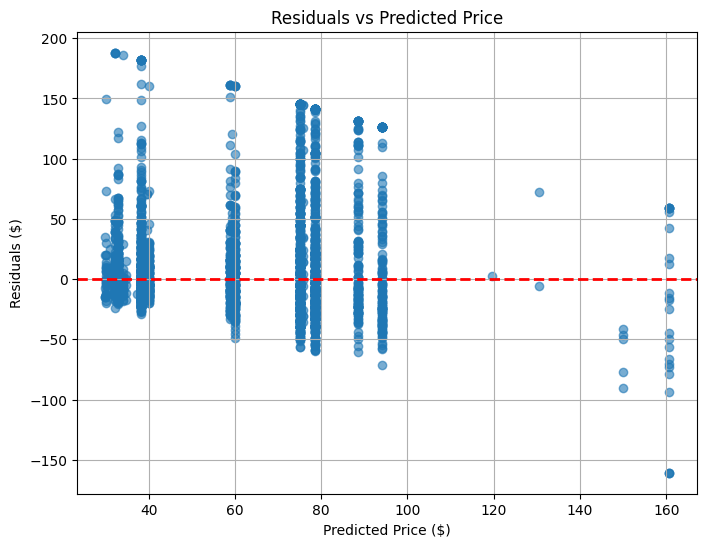

In [17]:
residuals = y_true - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals ($)")
plt.title("Residuals vs Predicted Price")
plt.grid(True)
plt.show()


In [15]:
host_input = pd.DataFrame([{
    "ROOM_TYPE": 1,
    "IS_SUPERHOST": 0,
    "MIN_NIGHTS_BIN": "standard"
}])

log_price = model.predict(host_input)
price = np.expm1(log_price)

print(price)

[32.97727862]


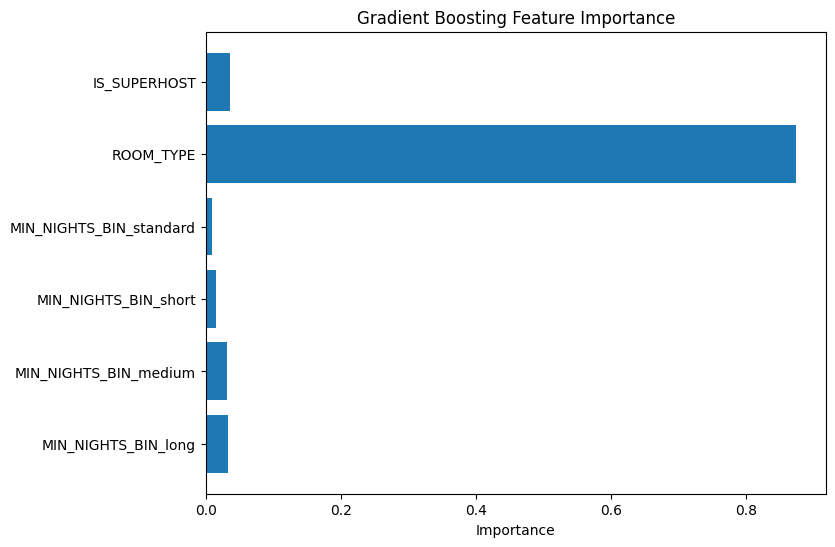

In [13]:
# Get the preprocessed feature names
onehot_features = model.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(["MIN_NIGHTS_BIN"])
numeric_features = ["ROOM_TYPE", "IS_SUPERHOST"]
feature_names = np.concatenate([onehot_features, numeric_features])

# Get feature importances
importances = model.named_steps["regressor"].feature_importances_

# Plot
plt.figure(figsize=(8,6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()